## Content Based Recommendation

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import ast
import json
import numpy as np
from numpy import genfromtxt
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import sklearn
from sklearn.metrics import precision_score, recall_score


In [2]:
df_clicks = pd.read_parquet('data/clicks.parquet')
df_stores = pd.read_parquet('data/stores.parquet')
df_users = pd.read_parquet('data/users.parquet')

In [3]:
sklearn.__version__

'0.24.1'

## Helper Functions

In [4]:


def get_cashback(x):
    if x in ('최대 4.0% 캐시백',
             '최대 1.5% 캐시백',
             '최대 1.0% 캐시백', 
             '최대 3.0% 캐시백',
             '최대 2.0% 캐시백',
             '최대 2.5% 캐시백',
             '최대 3.5% 캐시백',
             '최대 4.0% 캐시백',
             '최대 5.0% 캐시백',
             '최대 5.5% 캐시백',
             '최대 6.0% 캐시백',
             '최대 7.0% 캐시백',
            '최대 7.5% 캐시백',
             '최대 10.0% 캐시백',
             '최대 14.0% 캐시백',
            '최대 0.5% 캐시백',
            "최대 18000원 캐시백"):
        return x.split(' ')[1]
    elif x in ('캐시백 적립불가'):
        return '0%'
    else:
        return x.split(' ')[0]




def get_title_from_index(index,df):
    return df[df["index"]==index]["user_id"].values[0]

def get_index_from_title(user_id,df):
    return df[df["user_id"]==user_id]["index"].values[0]



def combined_features(row):
    return str(row['user_id']) + " "+ str(row["customer_age"]) + \
" " + row["channel"] + row["account_referral"] +" " + row["device"]  + " "\
+ row["platform"]  + str(row["is_new_user"]) + str(row["cashback"])

    

def get_nearest_user(query,df4U):    
    df4U["index"] = range(len(df4U))
    user_index = get_index_from_title(query,df4U)
    similar_users = list(enumerate(cosine_sim[user_index]))


    sorted_similar_users = sorted(similar_users,key=lambda x:x[1],reverse = True)
    i = 0
    similar_users = []
    for x in sorted_similar_users:
        sim_user = get_title_from_index(x[0],df4U)
        i+=1
        similar_users.append(sim_user)
        if i>10:
            break
    return similar_users






In [5]:
df_clicks.head()

,index,id,user_id,store_id,device,platform,channel,created_at
0,1242765,732810,28349,366,app_ios,iOS App,Direct,2021-02-03 23:47:27
1,400439,1367874,3553,424,mobile_android,Web,Display,2021-03-07 15:52:05
2,224227,1401055,53657,165,desktop,Web,Referral,2021-03-09 13:17:56
3,1628751,867093,236031,36,extension,Browser Extension,Extension,2021-02-09 12:57:00
4,34010,568663,3021,36,app_android,Android App,paid_ins_organic,2021-01-27 00:05:40


In [6]:
df_stores.head()

,id,merchant_id,start_at,end_at,display_text,is_searchable
0,0,0,2020-07-31 15:00:00,2029-12-31 14:59:00,1.0% 캐시백,1.0
1,1,1,2020-03-26 15:00:00,2029-12-31 14:59:59,1.0% 캐시백,1.0
2,2,2,2020-03-02 15:00:00,2028-12-31 14:59:00,3.0% 캐시백,1.0
3,3,3,2020-04-22 03:00:00,2050-04-30 03:00:00,1.0% 캐시백,1.0
4,4,4,2020-07-29 15:00:00,2050-07-31 14:59:00,최대 4.0% 캐시백,1.0


In [7]:
df_users.head()

,id,signup_datetime,lifetime_first_merchant_id,lifetime_first_purchase_datetime,account_referral
0,0,2021-03-20 14:15:59.392,NaN,None,partnership
1,1,2020-05-05 13:57:03.195,12251.0,2020-05-05 15:06:05.000,ebbonus5
2,2,2021-02-01 13:49:07.783,NaN,None,friend
3,3,2021-02-23 21:41:40.364,NaN,None,sign up
4,4,2021-01-27 16:46:25.400,NaN,None,sign up


## Create  Train and Test_dataset

In [8]:
clicks_train, clicks_test = train_test_split(df_clicks,test_size = 0.05,random_state = 42)
users_train = clicks_train["user_id"].unique()

users_test = clicks_test["user_id"].unique()

np.savetxt("users_train.csv",users_train,delimiter = ',')
np.savetxt("users_test.csv",users_test,delimiter = ',')


df2 = clicks_train.merge(df_stores,left_on = 'store_id', right_on = 'id', how = 'inner')

df3 = df2[(df2['created_at']>=df2['start_at']) & 
         (df2['created_at']<=df2['end_at'])]


df_test = clicks_test.merge(df_stores,left_on = 'store_id', right_on = 'id', how = 'inner')
df_test = df_test[(df_test['created_at']>=df_test['start_at']) & 
         (df_test['created_at']<=df_test['end_at'])]

df_test = df_test.merge(df_users, left_on = 'user_id',right_on = 'id',how = 'left')

# Exploratory Data Analysis


#### What are the most clicked merchant for month January 2021?
The merchant_id 40 looks to be the most popular in Jan 2021


In [9]:
temp = df3[(df3['created_at']>='2021-01-01') & 
           (df3['created_at']<='2021-02-01')]
temp.rename({'id_x':'click_id'}, inplace = True,axis = 1)
temp.groupby(['merchant_id']).agg({'click_id':'count'}).sort_values('click_id',ascending = False)

/Users/gfg_user/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,click_id
merchant_id,
399,10325
311,4472
185,4000
87,2680
111,2569
...,...
84,1
101,1
301,1


#### What are the distribution of clicks of merchant for month March 2021?


/Users/gfg_user/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4449: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


<AxesSubplot:>

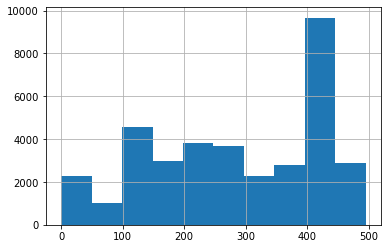

In [10]:
temp = df3[(df3['created_at']>='2021-03-01') & 
           (df3['created_at']<='2021-04-01')]
temp.rename({'id_x':'click_id'}, inplace = True,axis = 1)
#temp_agg = temp.groupby(['merchant_id']).agg({'click_id':'count'}).sort_values('click_id',ascending = False)
#temp_agg.reset_index(inplace = True)
temp[temp["merchant_id"]!=36]["merchant_id"].hist()

In [11]:
temp["merchant_id"].value_counts(normalize = True)

36     0.594151
399    0.083565
233    0.029936
280    0.027459
185    0.020911
         ...   
335    0.000011
406    0.000011
83     0.000011
494    0.000011
330    0.000011
Name: merchant_id, Length: 227, dtype: float64

### On average, what are the number of clicks user make in 1 month?

In [12]:
df3['count'] = np.ones(len(df3))
df3["month"] = df3["created_at"].apply(lambda x:datetime.strptime(x[0:10],'%Y-%m-%d').date().month)
df3m = df3.groupby(['month','user_id']).agg({'count':'sum'})
df3m.mean()

/Users/gfg_user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/gfg_user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


count    3.587618
dtype: float64

##  Feature Creation : Compute Ratings

In [13]:
df3['count'] = range(len(df3))
df_u_m = df3.groupby(['user_id','merchant_id']).agg({'count':'count'})
df_u_m.rename({'count':'user_merchant_count'},axis = 1,inplace = True)
df_u_m.reset_index(inplace = True)

#----------------------------_#
df_u = df3.groupby(['user_id']).agg({'count':'count'})
df_u.rename({'count':'user_count'},axis = 1,inplace = True)
df_u.reset_index(inplace = True)
df3 = df3.merge(df_u_m, on = ['user_id',
                              'merchant_id'], how = 'left')
df3 = df3.merge(df_u, on = ['user_id'], how = 'left')

df3['rating'] = 5* df3['user_merchant_count']/df3['user_count']
df4 = df3.merge(df_users, left_on = 'user_id',right_on = 'id',how = 'left')

/Users/gfg_user/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
most_frequent_merchant = df4['merchant_id'].value_counts().index[0]

In [15]:
df4.shape

(181842, 24)

In [16]:
cols = ['index',
 'id_x',
 'user_id',
 'store_id',
 'device',
 'platform',
 'channel',
 'created_at',
# 'id_y',
 'merchant_id',
 'start_at',
 'end_at',
 'display_text',
 'is_searchable',
 'count',
 'user_merchant_count',
 'user_count',
 'rating',
# 'id',
 'signup_datetime',
 'lifetime_first_merchant_id',
 'lifetime_first_purchase_datetime',
 'account_referral']
df4 = df4[cols]

## Feature Creation: Customer & Price Features

In [17]:
df4['created_at'] = df4["created_at"].apply(lambda x: datetime.strptime(x[0:10],'%Y-%m-%d').date())
df4['signup_datetime'] = df4["signup_datetime"].apply(lambda x: datetime.strptime(x[0:10],'%Y-%m-%d').date())

#-----


df4['is_new_user'] = np.where(df4['signup_datetime']==df4['created_at'],1,0)
df4['customer_age']  = df4['created_at'] - df4['signup_datetime']
df4['customer_age']  = df4['customer_age'].apply(lambda x:x.days)


In [18]:
df4['cashback'] = df4['display_text'].apply(lambda x:x[0])

    
df4['cashback'] = df4['display_text'].apply(lambda x:get_cashback(x))   
df4['cashback'] = df4['cashback'].apply(lambda x:x[:-1])  

In [19]:
imp_channels = df4['channel'].value_counts(normalize = True).index[0:7]

imp_accounts = df4['account_referral'].value_counts(normalize = True).index[0:7]
df4['customer_age'] = df4['customer_age'].astype(int)

df4['is_searchable'] = df4['is_searchable'].fillna(0)

df4["device"] = df4["device"].fillna("unknown")

df4["channel"] = df4["channel"].fillna("unknown")

In [20]:
features = ['user_id','customer_age','channel','account_referral','device','platform','is_new_user','cashback']



df4 = df4.drop_duplicates(subset = ["user_id"], keep = 'last')
df4["combined_features"]  = df4.apply(combined_features, axis = 1)
cv = CountVectorizer()

## Compute Cosine Similarity to find similar users

A cosine similarity is computed between users to find similar users

In [21]:

df4U = df4[["user_id",
            "combined_features"]].drop_duplicates(subset = ["user_id",
                                                                       "combined_features"], keep = 'last')
count_matrix = cv.fit_transform(df4U["combined_features"])

df4U.to_csv('df4U.csv')

count_matrix = count_matrix.astype('float32')
cosine_sim = cosine_similarity(count_matrix)
np.shape(cosine_sim)

(39691, 39691)

## Compute User -Merchant Ranking

In [22]:
user_ratings = df4[['user_id','merchant_id','user_merchant_count']].groupby(['user_id','merchant_id']).agg({'user_merchant_count':'mean'})

user_ratings.reset_index(inplace = True)
user_ratings_pivot = user_ratings.pivot(index = 'user_id',
                                columns = 'merchant_id',
                                values = 'user_merchant_count')
user_ratings_pivot.fillna(0,inplace = True)

In [23]:
user_ratings_pivot2 = user_ratings_pivot.T
user_merch = {}
user_lst = user_ratings_pivot2.columns
for user in user_lst:
    if user not in user_merch:
        user_merch[user] = [np.where(user_ratings_pivot2[user]>0)[0]]
    else:
        user_merch[user].append(np.where(user_ratings_pivot2[user]>0)[0])
        

In [24]:
def get_user_id(test_data):
    return(test_data['user_id'].unique())

user_test = df_test['user_id']
y_test = np.array(df_test['merchant_id'])
user_test = np.array(df_test['user_id'])

In [25]:

df = pd.DataFrame(user_merch)
df.to_csv("user_merch.csv", index = False)

In [26]:
dfu = pd.read_csv("user_merch.csv", index_col = None)
dfu.head()

,1,7,11,12,20,32,34,43,61,62,...,250394,250399,250401,250403,250404,250411,250418,250425,250435,250442
0,[190],[2],[118],[58],[130],[63],[59],[108],[149],[130],...,[184],[227],[17],[173],[190],[78],[58],[163],[19],[19]


In [27]:
def batch_predict(user_test):
    no_neighbor = 0
    user_merch = pd.read_csv("user_merch.csv", index_col = None)
    df4U = pd.read_csv('df4U.csv')
    users_train = genfromtxt('users_train.csv', delimiter=',')
    users_train = [int(i) for i in users_train]
    
    
    user_merch.columns = [int(i) for i in user_merch.columns]
    for col in user_merch.columns:
        user_merch[col] = ast.literal_eval(user_merch[col][0])[0]

    predictions = []
    for user in user_test:
        if user in users_train:
            if user in user_merch.keys():
                predictions.append(user_merch[user][0])
                continue
            else:
                if user in df4U['user_id'].unique():
                    nearest_user = get_nearest_user(user,df4U)
                    while nearest_user:
                        u = nearest_user.pop(0)
                        if u in user_merch.keys():
                            predictions.append(user_merch[u][0])
                            print(user_merch[u][0])
                            break
                else:
                    predictions.append(most_frequent_merchant)
        else:
            predictions.append(most_frequent_merchant)
    return predictions



def predict(user):
    no_neighbor = 0
    user_merch = pd.read_csv("user_merch.csv", index_col = None)
    df4U = pd.read_csv('df4U.csv')
    users_train = genfromtxt('users_train.csv', delimiter=',')
    users_train = [int(i) for i in users_train]
    
    user_merch.columns = [int(i) for i in user_merch.columns]
    for col in user_merch.columns:
        user_merch[col] = ast.literal_eval(user_merch[col][0])[0]

    predictions = []
    if user in users_train:
        if user in user_merch.keys():
            predictions.append(user_merch[user][0])
            return predictions
        else:
            if user in df4U['user_id'].unique():
                nearest_user = get_nearest_user(user,df4U)
                while nearest_user:
                    u = nearest_user.pop(0)
                    if u in user_merch.keys():
                        predictions.append(user_merch[u][0])
                        return predictions
            else:
                predictions.append(most_frequent_merchant)
                return predictions
    else:
        predictions.append(most_frequent_merchant)
    return predictions

In [28]:
predictions = batch_predict(user_test)


## Performance Evaluation

The recommender system is like a multiclass classification problem. Two metrics will be used to measure the accuracy of the scores - Precision and Recall. The values of Precision 
and Recall will be measured against different merchant - ids

In [29]:
def Precision(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if sum(y_true[i]) == 0:
              continue
        temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_true[i])
    return temp/ y_true.shape[0]

def Recall(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        if sum(y_pred[i]) == 0:
              continue
    temp+= sum(np.logical_and(y_true[i], y_pred[i]))/ sum(y_pred[i])
    return temp/ y_true.shape[0]

In [30]:
y_test_u = list(set(y_test))
arr_results = {}
arr_prec = precision_score(list(y_test), predictions, average= None)
arr_rec = recall_score(list(y_test), predictions, average=None)
for i in range(len(y_test_u)):
    arr_results[y_test_u[i]] = [arr_prec[i],arr_rec[i]]
    
    

/Users/gfg_user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gfg_user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:

res = pd.DataFrame(arr_results).T
res.reset_index(inplace = True)
res.columns = ["merchant_id","precision","recall"]
res


,merchant_id,precision,recall
0,0,0.285714,0.500000
1,1,0.107143,0.272727
2,2,0.459459,0.708333
3,3,0.000000,0.000000
4,4,0.000000,0.000000
...,...,...,...
194,487,0.000000,0.000000
195,491,0.000000,0.000000
196,492,0.000000,0.000000
197,493,0.000000,0.000000


In [32]:
print('Precision:',precision_score(list(y_test), predictions, average= 'weighted'),
                                   'Recall:',recall_score(list(y_test), 
                                    predictions, average='weighted'))

Precision: 0.06113504044279361 Recall: 0.01740506329113924


/Users/gfg_user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/gfg_user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
precision_score(list(y_test), predictions, average= None)

/Users/gfg_user/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([0.28571429, 0.10714286, 0.45945946, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.17374517, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [34]:
sklearn.__version__

'0.24.1'